In [59]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import util
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

relevant links:
- https://news.artnet.com/exhibitions/bodys-isek-kingelez-moma-1104215

In [60]:
artist_df = pd.read_pickle('data/artist_04092018.pkl')
exhibition_df = pd.read_pickle('data/exhibition_04092018.pkl')

In [3]:
def artist_by_exhibit_year(year, code="A", print_graphs=False, raw=False):
    """
    Code meaning:
    "A" = American Artist race breakdown
    "B" = American Artist gender breakdown
    "C" = Non-American Artist race breakdown
    "D" = Non-American Artist gender breakdown
    "E" = All Artist nationality breakdown
    """
    
    museum = "The Museum of Modern\xa0Art"
    # museum = "MoMA\xa0PS1"
    
    fil = (exhibition_df['artists'] != '') & (exhibition_df['year'] == year) & (exhibition_df['museum'] == museum)
    artist_filter = ', '.join(list(exhibition_df[fil]["artists"])).split(', ')
    artist_filter_df = pd.DataFrame(artist_filter, columns=["artist_name"])
    
    artist_filter_merged_df = artist_filter_df.merge(artist_df[["artist_name", "race", "gender", "nationality"]], on=["artist_name"])

    artist_filter_american_df = artist_filter_merged_df[artist_filter_merged_df['nationality']=='American']
    artist_filter_non_american_df = artist_filter_merged_df[artist_filter_merged_df['nationality']!='American']

    
    if print_graphs:
        fig = plt.figure(figsize=(10,5))
        plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)
        ax1 = fig.add_subplot(111)
        
        if code == "A":
            util.plot_distribution(dist_df=artist_filter_american_df[artist_filter_american_df['race']!='']['race'].value_counts(dropna=True),
                title="Race Distribution of \nAmerican Artists Who Have Exhibited During %i"%year,
                ax=ax1)
        if code == "B":
            util.plot_distribution(dist_df=artist_filter_american_df[artist_filter_american_df['gender']!="None"]['gender'].value_counts(dropna=True),
                title="Gender Distribution of \nAmerican Artists Who Have Exhibited During %i"%year,
                ax=ax1, show_pct=True)
        if code == "C":
            util.plot_distribution(dist_df=artist_filter_non_american_df[artist_filter_non_american_df['race']!='']['race'].value_counts(dropna=True),
                title="Race Distribution of \nNon American Artists Who Have Exhibited During %i"%year,
                ax=ax1)
        if code == "D":
            util.plot_distribution(dist_df=artist_filter_non_american_df[artist_filter_non_american_df['gender']!="None"]['gender'].value_counts(dropna=True),
                title="Gender Distribution of \nNon American Artists Who Have Exhibited During %i"%year,
                ax=ax1, show_pct=True)
        if code == "E":
            util.plot_distribution(dist_df=artist_filter_merged_df[artist_filter_merged_df['nationality']!='']['nationality'].value_counts(dropna=True).iloc[0:10,],
                title="Gender Distribution of \nNon American Artists Who Have Exhibited During %i"%year,
                ax=ax1)
    
    if raw:
        if code == "A" or code == "B":
            return artist_filter_american_df
        if code == "C" or code == "D":
            return artist_filter_non_american_df
        if code == "E":
            return artist_filter_merged_df
    else:
        if code == "A":
            return artist_filter_american_df[artist_filter_american_df['race']!='']['race'].value_counts(dropna=True)
        if code == "B":
            return artist_filter_american_df[artist_filter_american_df['gender']!="None"]['gender'].value_counts(dropna=True)
        if code == "C":
            return artist_filter_non_american_df[artist_filter_non_american_df['race']!='']['race'].value_counts(dropna=True)
        if code == "D":
            return artist_filter_non_american_df[artist_filter_non_american_df['gender']!="None"]['gender'].value_counts(dropna=True)
        if code == "E":
            return artist_filter_merged_df[artist_filter_merged_df['nationality']!='']['nationality'].value_counts(dropna=True).iloc[0:10,]

In [4]:
start_year = 1930
end_year = 2018

In [5]:
def plot_time_series(code, start, end, title, omit=[]):
    title = title + " between %i and %i"%(start, end)
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    time_series = pd.DataFrame([], columns=["year"])
    
    for i in range(start, end):
        t = artist_by_exhibit_year(i, code, print_graphs=False).to_dict()
        t['year'] = i
        time_series = time_series.append(t, ignore_index=True)

    time_series = time_series.set_index("year")
    time_series = time_series.fillna(value=0)
    
    # omit columns
    if len(omit) > 0:
        time_series = time_series.drop(omit, axis=1)
        
    # get top 10 at max
    column_filter = time_series.sum().sort_values(ascending=False).index[:10]
    time_series = time_series[column_filter]

    # plot quantity
    time_series.plot(ax=ax1, title=title)
    ax1.set_ylim(bottom=0)

    # plot pct
    feature_pct_df = time_series.divide(time_series.sum(axis=1) +.000000001, axis=0)
    feature_pct_df.plot(ax=ax2, title=title + " [PCT]")
    ax2.set_ylim(top=1, bottom=0)

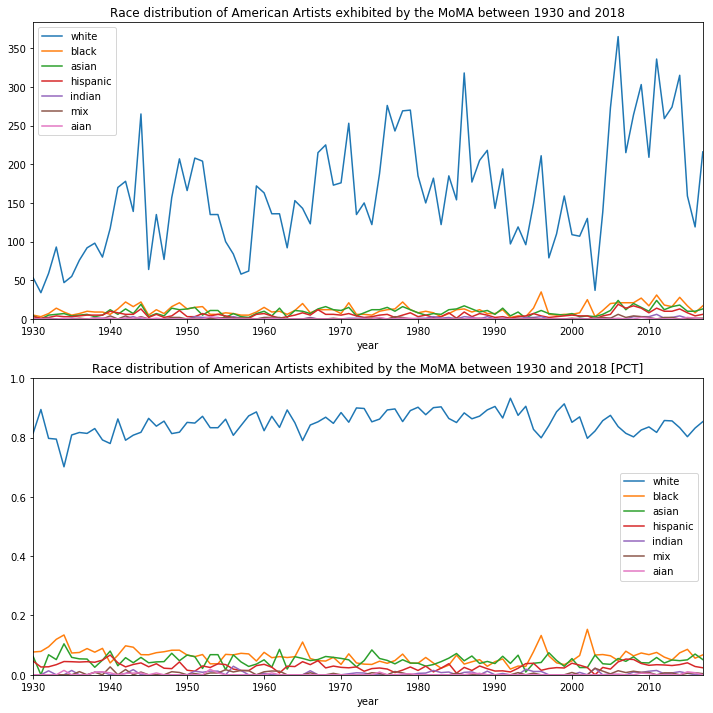

In [6]:
plot_time_series(code="A", \
                 start=start_year, \
                 end=end_year, \
                 title="Race distribution of American Artists exhibited by the MoMA", \
                 omit=[])

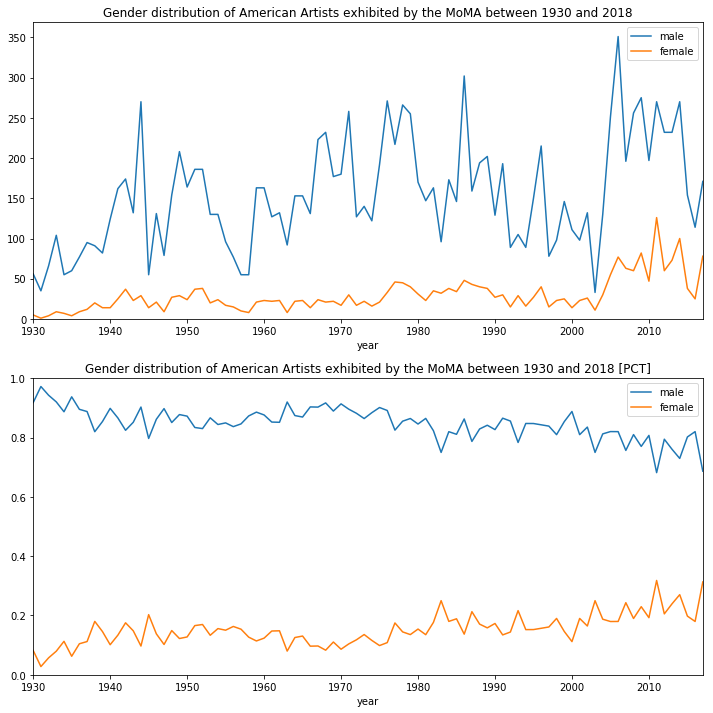

In [7]:
plot_time_series(code="B", \
                 start=start_year, \
                 end=end_year, \
                 title="Gender distribution of American Artists exhibited by the MoMA", \
                 omit=[])

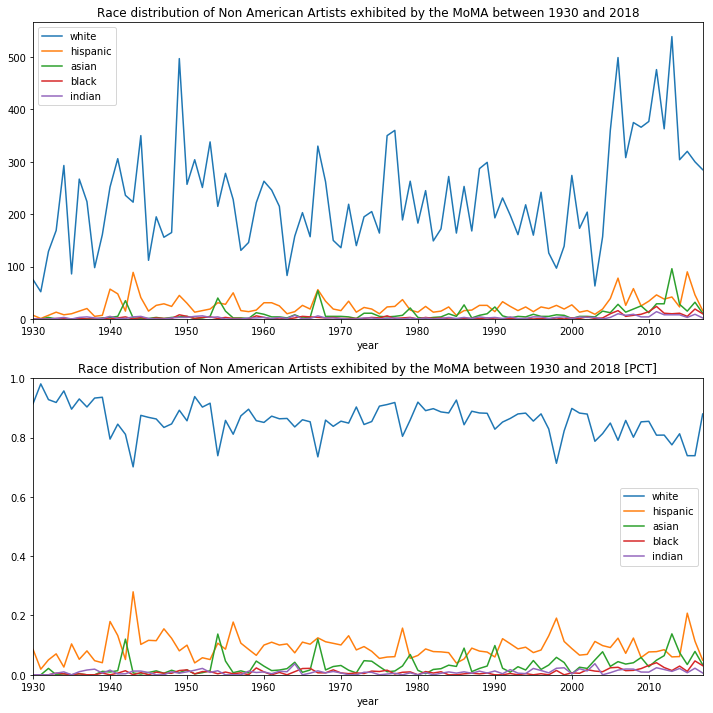

In [8]:
plot_time_series(code="C", \
                 start=start_year, \
                 end=end_year, \
                 title="Race distribution of Non American Artists exhibited by the MoMA", \
                 omit=[])

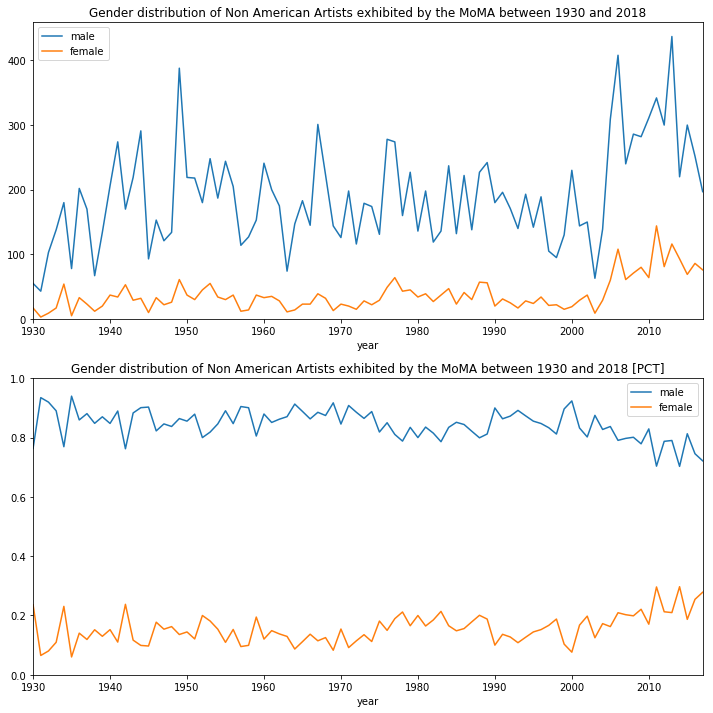

In [9]:
plot_time_series(code="D", \
                 start=start_year, \
                 end=end_year, \
                 title="Gender distribution of Non American Artists exhibited by the MoMA", \
                 omit=[])

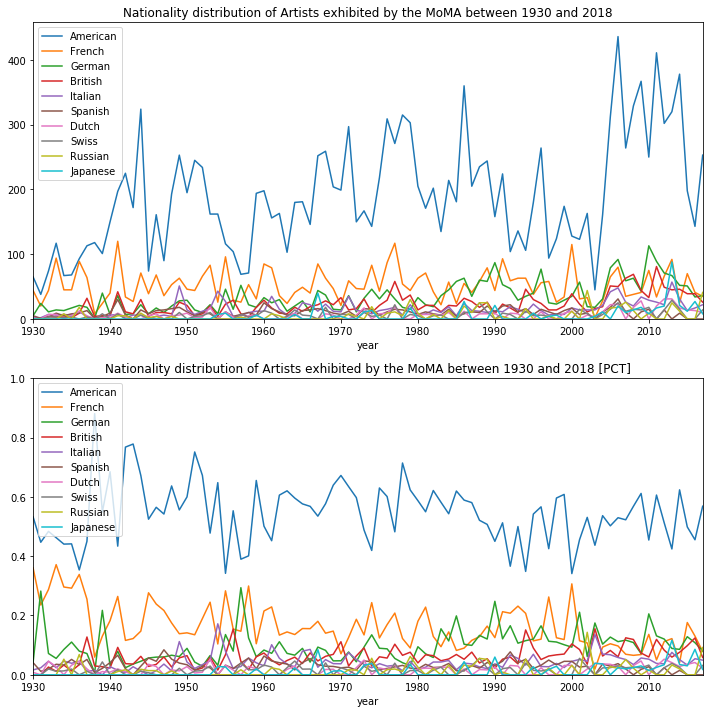

In [10]:
plot_time_series(code="E", \
                 start=start_year, \
                 end=end_year, \
                 title="Nationality distribution of Artists exhibited by the MoMA", \
                 omit=[])

In [11]:
def plot_race_gender_across_years(years=[1957, 1977, 1997, 2017], code="A"):
    """
    This function will print out 2 graphs to show the race and gender distribution of artists who have
    exhibited at the MoMA, across the 4 years that
    Code:
    - "A"/"B" for Americans only
    - "C"/"D" for Non-Americans
    - "E" for both
    """
    df_array = []
    for year in years:
        df_array.append(artist_by_exhibit_year(year, code=code, print_graphs=False, raw=True))

    fig = plt.figure(figsize=(12, 15))
    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)
    
    axes = []
    for i in range(1, 2 * len(years) + 1):
        axes.append(fig.add_subplot(4, 2, i))

    for i, year in enumerate(years):
        util.plot_distribution(dist_df=df_array[i][df_array[i]['race']!='']['race'].value_counts(dropna=True),
            title="Race Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[2*i])

        util.plot_distribution(dist_df=df_array[i][df_array[i]['gender']!='None']['gender'].value_counts(dropna=True),
            title="Gender Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[(2*i)+1])
        

def plot_nationality_across_years(years=[1957, 1977, 1997, 2017]):
    """
    This function will print out 2 graphs to show the race and gender distribution of artists who have
    exhibited at the MoMA, across the 4 years that
    """
    df_array = []
    for year in years:
        df_array.append(artist_by_exhibit_year(year, code="E", print_graphs=False, raw=True))

    fig = plt.figure(figsize=(12, 15))
    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)
    
    axes = []
    for i in range(1, len(years) + 1):
        axes.append(fig.add_subplot(4, 1, i))

    for i, year in enumerate(years):
        util.plot_distribution(dist_df=df_array[i][df_array[i]['nationality']!='']['nationality'].value_counts(dropna=True)[:10],
            title="Nationality Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[i], show_pct=False)

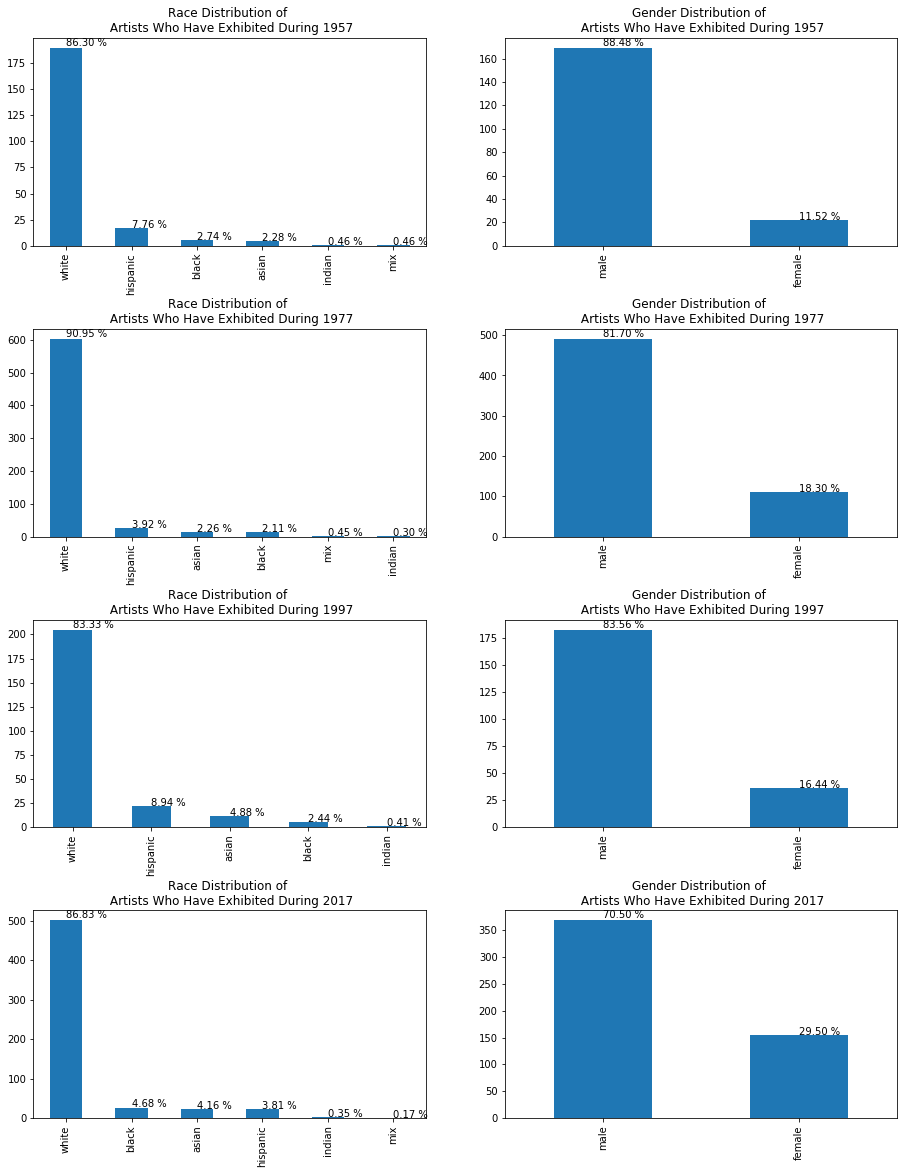

In [12]:
plot_race_gender_across_years(years=[1957, 1977, 1997, 2017], code="E")

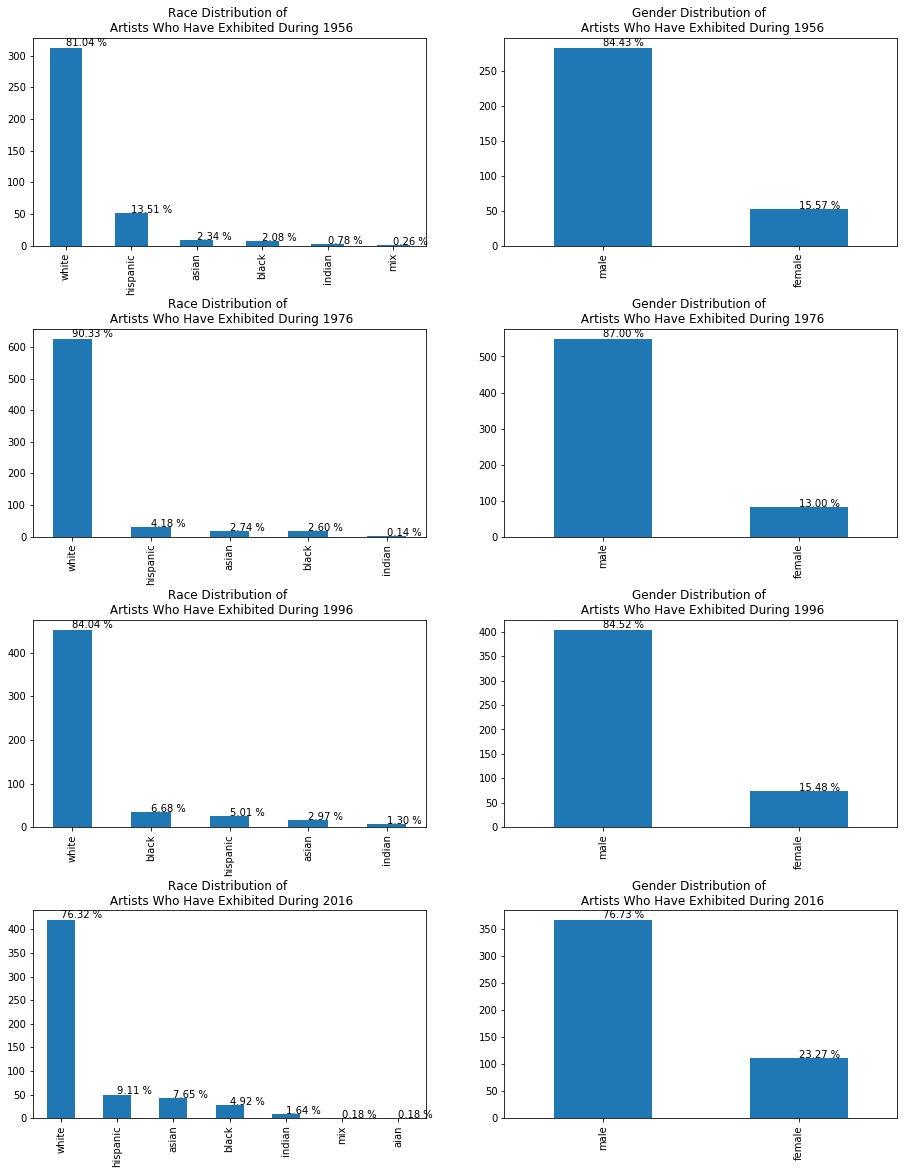

In [21]:
plot_race_gender_across_years(years=[1956, 1976, 1996, 2016], code="E")

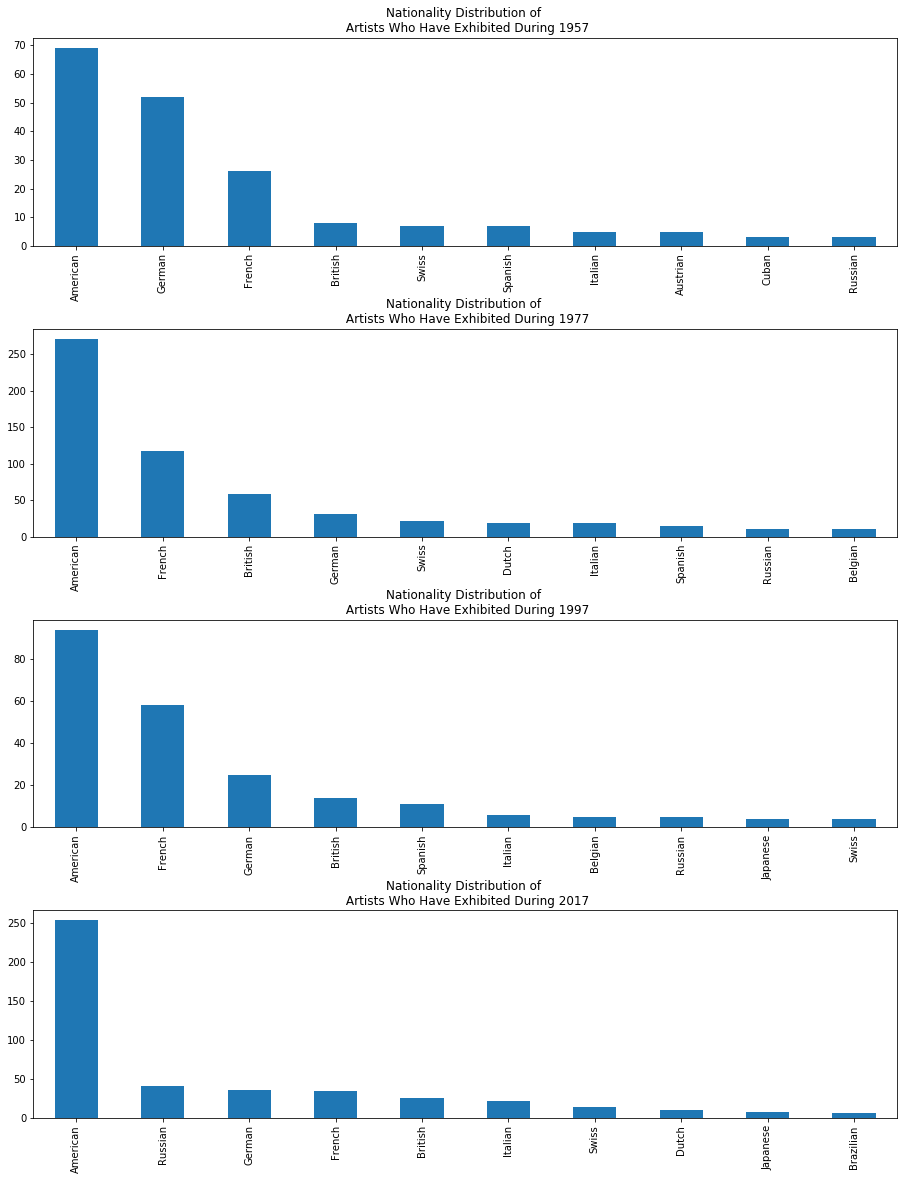

In [13]:
plot_nationality_across_years()

In [18]:
def get_top_exhibited_artists(start, end, code, top=50, plot=True):
    time_series = pd.DataFrame([])

    for i in range(start, end):
        t = artist_by_exhibit_year(i, code, print_graphs=False, raw=True)
        time_series = time_series.append(t, ignore_index=True)

    ret = time_series.groupby(time_series.columns.tolist(), as_index=False)\
        .size().reset_index().rename(columns={0: 'count'})\
        .sort_values(by='count', ascending=False)\
        .reset_index().drop("index", axis=1).iloc[0:top]
        
    if plot:
        fig = plt.figure(figsize=(5,5))
        plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)
        ax1 = fig.add_subplot(111)
        if code == "A" or code == "C":
            util.plot_distribution(dist_df=ret["race"].value_counts(dropna=True),
                title="Race Distribution of the MoMA's Top 100 Most Exhibited Artists",
                ax=ax1, show_pct=True)
        if code == "B" or code == "D":
            util.plot_distribution(dist_df=ret["gender"].value_counts(dropna=True),
                title="Gender Distribution of the MoMA's Top 100 Most Exhibited Artists",
                ax=ax1, show_pct=True)
        if code == "E":
            util.plot_distribution(dist_df=ret["nationality"].value_counts(dropna=True),
                title="Nationality Distribution of the MoMA's Top 100 Most Exhibited Artists",
                ax=ax1, show_pct=True)
    else:
        return ret

In [19]:
get_top_exhibited_artists(2007, 2017, code="A", top=100, plot=False).head(5)
# in the past 10 years, there have been 95 american artists whose work has been exhibited more than 5 times
# of those 95, only 5 are PoC (2 hispanics, 2 blacks, and 1 asian)

,artist_name,race,gender,nationality,count
0,Bruce Nauman,white,male,American,19
1,Robert Rauschenberg,white,male,American,19
2,Man Ray (Emmanuel Radnitzky),white,male,American,18
3,Marcel Duchamp,white,male,American,16
4,John Baldessari,white,male,American,16


In [20]:
get_top_exhibited_artists(2007, 2017, code="C", top=86, plot=False).head(5)
# in the past 10 years, there have been 86 non-american artists whose work has been exhibited more than 5 times
# of those 86, only 10 are PoC (7 hispanics, and 3 asian)

,artist_name,race,gender,nationality,count
0,Pablo Picasso,hispanic,male,Spanish,19
1,Joseph Beuys,white,male,German,16
2,Marcel Broodthaers,white,male,Belgian,13
3,Rem Koolhaas,white,male,Dutch,13
4,Dieter Roth,white,male,Swiss,13


In [58]:
artist_df.to_pickle('data/artist_04092018.pkl')

In [61]:
artist_df[(artist_df["year"]=="2013")]["race"].value_counts()# & (artist_df["race"]=="white")]

KeyError: 'year'

In [52]:
def check_race_and_gender(row):
    """
    manual checked american & non-american artists of years: 1957, 1977, 1997 & 2017
    """
    
    white_male_list = [\
        "sol lewitt", "ellsworth kelly", "edward ruscha", "john marin", "philip guston", "jonathan borofsky", \
        "william brice", "robert morris", "ben shahn", "e. mcknight kauffer", "robert andrew parker", "jan müller", \
        "jules pascin", "william t. wiley", "mark rothko", "varujan boghosian", "raoul hague", "joseph glasco", \
        "robert wilson", "garry winogrand", "albert alcalay", "gandy brodie", "frank lloyd wright", "raimund abraham", \
        "morris graves", "christopher wool", "merce cunningham", "louis michel eilshemius", "robert brownjohn", \
        "woody vasulka", "sam francis","robert indiana", "william wegman", "gordon matta-clark", "mel bochner", \
        "willem de kooning", "milton avery", "felix gonzalez-torres", "douglas huebler", "r. buckminster fuller", \
        "tom wesselmann", "terry allen", "william bailey", "robert mapplethorpe", "richard foreman", "rafael ferrer", \
        "pirkle jones", "philippe halsman", "peter campus", "charles atlas", "douglas davis", "caldecot chubb", \
        "ben schonzeit", "jared bark", "jerry uelsmann", "abraham walkowitz", "peter young", "roger brown", \
        "tim rollins", "leon polk smith", "david park", "charles fahlen", "barry le va", "ian (hugh guiler) hugo", \
        "king vidor", "walter lang", "walter burley griffin", "val telberg", "paul taylor", "r. crumb", "remy charlip", \
        "robert breer", "bruce graham", "busby berkeley", "charles gwathmey", "charles j. brabin", "david levinthal", \
        "albert herbert", "allan mccollum", "eugene masselink", "george cukor", "willy mucha", "théo van rysselberghe", \
        "théophile-alexandre steinlen", "rené magritte", "hans namuth", "tom wesselmann", "mark di suvero", \
        "robert watts", "abraham walkowitz", "russell lee", "robert capa", "barry le va", "jerry uelsmann", \
        "george nelson", "joel meyerowitz", "william lescaze", "francis bruguière", "philip evergood", "jim shaw", \
        "george him", "günther förg", "rené robert bouché", "esteban vicente", "peter grippe", "mark grotjahn", \
        "john hejduk", "cornell capa", "robert gwathmey", "robert heinecken", "ed emshwiller", "donald sultan", \
        "gregory amenoff", "nathan george horwitt", "maurice sterne", "jean charlot", "timothy o'sullivan", \
        "alton pickens", "louis faurer", "richard neutra", "louis lozowick", "alfred leslie", "morris louis", \
        "kim jones", "carleton e. watkins", "william vandivert", "jules olitski", "louis schanker", \
        "walter dorwin teague", "edward kienholz", "nathan lyons", "walter robinson", "larry poons", "john steuart curry", \
        "alphonse mucha", "robert laurent", "bill beckley", "alfred eisenstaedt", "harwell hamilton harris", \
        "thomas wilfred", "ron davis", "geoffrey hendricks", "alain kirili"]
    
    white_female_list = [\
        "helen frankenthaler", "lee bontecou", "yvonne rainer", "imogen cunningham", "charmion von wiegand", "angelo testa" \
        "louise nevelson", "adrian piper", "elizabeth murray", "mona hatoum", "lee krasner", "lois long", \
        "claire (claire mahl) moore", "alexis smith", "trisha brown", "lucinda childs", "margaret c. anderson", \
        "vera (vera neumann)", "susan weil", "noémi raymond", "pat passlof", "jan groover", "elaine de kooning", \
        "nancy holt", "susan weil", "wanda gág", "elizabeth peyton", "judith joy ross", "louise dahl-wolfe", \
        "jane dickson"]
    
    asian_female_list = [\
        "elizabeth mcfadden", "tomiyo sasaki"]
    
    asian_male_list = [\
        "shusaku arakawa", "lee ufan", "wifredo lam", "ai weiwei", "chinn yuen-yuei", "thomas han", \
        "jenova (xinghan) chen", "eikoh hosoe", "ken domon", "lee jong-ok"]
    
    black_male_list = [\
        "david hammons", "kingelez", "raymond saunders", "melvin edwards", "sam gilliam", "Cameron Rowland", \
        "terry adkins", "jacob lawrence", "gordon parks"]
    
    black_female_list = [\
        "minnie evans", "kara walker", "xaviera simmons", "carrie mae weems", "alma woodsey thomas", \
        "barbara chase-riboud"]
    
    hispanic_female_list = [\
        "andrea bowers", "andrea fraser"]
    
    hispanic_male_list = [\
        "rufino tamayo"]
    
    none_list = [\
        "velox ward", "dudley huppler", "schilli maier", "maxi cohen", "richard w. landis", "skip blumberg", \
        "joel fisher", "eve sonneman", "mia ferrara", "john h. lickert", "william c. gannett", "robert p. gottlieb", \
        "orlando giannini", "daniel larossa", "alfred w. fielding", "arthur a. aykanian", "don weinreich", \
        "janet stein", "eliza montgomery", "elizabeth mock", "roland baladi"]
    
    if "nknown" in row['artist_name'].lower() \
        or "nonymous" in row['artist_name'].lower() \
        or "rtist" in row['artist_name'].lower() \
        or "ystem" in row['artist_name'].lower() \
        or "group" in row['artist_name'].lower() \
        or "corp" in row['artist_name'].lower() \
        or ", " in row['artist_name'].lower() \
        or "ssociates" in row['artist_name'].lower() \
        or "tudio" in row['artist_name'].lower() \
        or "esearch" in row['artist_name'].lower() \
        or "imension" in row['artist_name'].lower() \
        or "skidmore" in row['artist_name'].lower() \
        or "rchitect" in row['artist_name'].lower() \
        or row['artist_name'].lower() in none_list:
        return None, None
    
    if row['artist_name'].lower() in white_male_list:
        return "white", "male"
    
    if row['artist_name'].lower() in white_female_list:
        return "white", "female"
    
    if row['artist_name'].lower() in asian_female_list:
        return "asian", "female"
    
    if row['artist_name'].lower() in asian_male_list:
        return "asian", "male"
    
    if row['artist_name'].lower() in black_male_list:
        return "black", "male"
    
    if row['artist_name'].lower() in black_female_list:
        return "black", "female"
    
    if row['artist_name'].lower() in hispanic_female_list:
        return "hispanic", "female"
    
    if row['artist_name'].lower() in hispanic_male_list:
        return "hispanic", "male"
    
    return row['race'], row['gender']

artist_df[['race', 'gender']] = artist_df.apply(lambda x: pd.Series(check_race_and_gender(x)), axis=1)